In [1]:
import ee

ee.Authenticate()
ee.Initialize(project='cibravo2')

In [5]:
import geopandas as gpd
import pandas as pd

data = gpd.read_file('data_center.geojson').to_crs(4326)
center = data[data['Name'] == 'RODRIGUEZ (EA15-110823)']
center

,Name,geometry
29,RODRIGUEZ (EA15-110823),POINT Z (-73.50121 -45.37232 0.00000)


In [4]:
import json

aoi = gpd.GeoSeries(center['geometry'].buffer(0.03)).to_crs(4326).to_json()
aoi_bbox = ee.Geometry.Polygon(json.loads(aoi)['features'][0]['geometry']['coordinates'], 'EPSG:4326')


C:\Users\jacmo\AppData\Local\Temp\ipykernel_12668\3792296129.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi = gpd.GeoSeries(center['geometry'].buffer(0.03)).to_crs(4326).to_json()


In [19]:


def get_copernicus_collection(aoi, dates, clouds=10):
    collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate(dates[0], dates[1])
    collection = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', clouds))
    collection = collection.map(preprocess)
    collection = collection.sort('system:time_start', False)
    images = collection.aggregate_array('system:id').getInfo()
    print(f'Se obtuvieron {len(images)} imágenes del COPERNICUS')
    return collection, images

def get_modis_collection(aoi, dates, clouds=10):
    collection = ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI').filterBounds(aoi).filterDate(dates[0], dates[1])
    # collection = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', clouds))
    collection = collection.sort('system:time_start', False)
    images = collection.aggregate_array('system:id').getInfo()
    print(f'Se obtuvieron {len(images)} imágenes del MODIS')
    return collection, images


def preprocess(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    optical_bands = image.select('B.').multiply(0.0001)
    return image.addBands(ndvi).addBands(optical_bands, None, True)


def get_dates(modis_collection):
    dates = modis_collection.aggregate_array('system:time_start').getInfo()
    dates = [pd.to_datetime(date, unit='ms') for date in dates]
    dates = [date.strftime('%Y-%m-%d') for date in dates]

    return dates

dates = ['2020-12-11', '2022-12-12']
collection_copernicus, images_copernicus = get_copernicus_collection(aoi_bbox, dates, clouds=1)
collection_modis, images_modis = get_modis_collection(aoi_bbox, dates, clouds=1)

dates_copernicus = get_dates(collection_copernicus)
dates_modis = get_dates(collection_modis)
fechas = set(dates_copernicus) & set(dates_modis)
print(f'Se trabajará con {len(fechas)} imágenes')


Se obtuvieron 13 imágenes del COPERNICUS
Se obtuvieron 402 imágenes del MODIS
Se trabajará con 11 imágenes


In [16]:
import geemap

image_copernicus = collection_copernicus.median()
image_copernicus = image_copernicus.clip(aoi_bbox) 


image_modis = collection_modis.median()
image_modis = image_modis#.clip(aoi_bbox) 

# -73.50121 -45.37232
Map = geemap.Map(center=[-45.37232, -73.50121], zoom=16)
Map.addLayer(aoi_bbox)

imageRGB = image_copernicus.visualize(**{'bands': ['TCI_R', 'TCI_G', 'TCI_B'],'min':0, 'max': 100})
Map.addLayer(imageRGB, {}, 'RGB', True)

imageModis = image_modis.visualize(**{'bands': ['chlor_a',],'min':0, 'max': 100})
Map.addLayer(imageModis, {}, 'modis', True)

Map

Map(center=[-45.37232, -73.50121], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [83]:
'''
Se obtiene cada una de las imágenes para el satélite MODIS-AQUA.
Se almacenan localmente en disco para luego poder ser poligonizadas a través de GDAL.
'''

for fecha in fechas:
    dayOfInterest = ee.Date(fecha)
    # Obtenemos la imagen del satélite MODIS para ese día

    modisCollection = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
    .filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
    .filterBounds(aoi)\
    .select("chlor_a").first()

    geemap.ee_export_image(modisCollection, scale=4616, filename=f'MODIS/{fecha}.tif', region=aoi)  

    
    

Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2019-08-19.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2019-02-03.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2020-04-08.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2020-11-19.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2022-02-22.tif
Generating URL ...
Please wait ...
Data downloaded to c:\Users\jacmo\OneDrive - uc.cl\Documentos\cosas de la u\17. XVII\4. CDG\Proyecto\MODIS\2021-12-09.tif
Generating URL ...
Please wait ...
Data downloaded to c:\U

In [17]:
# Enhanced vegetation index (EVI)

def calculate_evi(collection_images):
 
    evi_collection = collection_images.map(lambda image: image.expression(
        '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ))

    return evi_collection

# Normalized Ratio Vegetation Index (NRVI)
def calculate_nrvi(collection_images):
    nrvi_collection = collection_images.map(lambda image: image.expression(
        '(RED/NIR - 1) / (RED/NIR + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return nrvi_collection

# Normalized Difference Water Index (NDWI)
def calculate_ndwi(collection_images):
    ndwi_collection = collection_images.map(lambda image: image.expression(
        '(GREEN - NIR) / (GREEN + NIR)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    ))

    return ndwi_collection

# Normalized Difference Water Index (NDWI2)   ndvi_2 es un typo
def calculate_ndvi2(collection_images):
    ndvi2_collection = collection_images.map(lambda image: image.expression(
        '(NIR - SWIR2) / (NIR + SWIR2)',
        {
            'NIR': image.select('B8'),
            'SWIR2': image.select('B12')
        }
    ))

    return ndvi2_collection

# Modified Normalized Difference Water Index (MNDWI)
def calculate_mndwi(collection_images):
    mndwi_collection = collection_images.map(lambda image: image.expression(
        '(GREEN - SWIR2) / (GREEN + SWIR2)',
        {
            'GREEN': image.select('B3'),
            'SWIR2': image.select('B12')
        }
    ))

    return mndwi_collection

# Green Normalized Difference Vegetation Index
def calculate_gndvi(collection_images):
    gndvi_collection = collection_images.map(lambda image: image.expression(
        '(NIR - GREEN) / (NIR + GREEN)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    ))

    return gndvi_collection

# Normalized Difference Vegetation Index
def calculate_ndvi(collection_images):
    ndvi_collection = collection_images.map(lambda image: image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return ndvi_collection

# Indices de bandas

def calculate_b3b1(collection_images):
    b3b1_collection = collection_images.map(lambda image: image.expression(
        'GREEN / AEROSOLS',
        {
            'GREEN': image.select('B3'),
            'AEROSOLS': image.select('B1')
        }
    ))

    return b3b1_collection


def calculate_b3b2(collection_images):
    b3b2_collection = collection_images.map(lambda image: image.expression(
        'GREEN / BLUE',
        {
            'GREEN': image.select('B3'),
            'BLUE': image.select('B2')
        }
    ))

    return b3b2_collection

def calculate_b3b4(collection_images):
    b3b4_collection = collection_images.map(lambda image: image.expression(
        'GREEN / RED',
        {
            'GREEN': image.select('B3'),
            'RED': image.select('B4')
        }
    ))

    return b3b4_collection

def calculate_b5b4(collection_images):
    b5b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_1 / RED',
        {
            'RED_EDGE_1': image.select('B5'),
            'RED': image.select('B4')
        }
    ))

    return b5b4_collection

def calculate_b6b4(collection_images):
    b6b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_2 / RED',
        {
            'RED_EDGE_2': image.select('B6'),
            'RED': image.select('B4')
        }
    ))

    return b6b4_collection

def calculate_b7b4(collection_images):
    b7b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_3 / RED',
        {
            'RED_EDGE_3': image.select('B7'),
            'RED': image.select('B4')
        }
    ))

    return b7b4_collection

def calculate_b8ab4(collection_images):
    b8ab4_collection = collection_images.map(lambda image: image.expression(
        'NIR / RED',
        {
            'NIR': image.select('B8A'),
            'RED': image.select('B4')
        }
    ))

    return b8ab4_collection

def calculate_b8b4(collection_images):
    b8b4_collection = collection_images.map(lambda image: image.expression(
        'NIR / RED',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return b8b4_collection

def calculate_oc2(collection_images):
    oc2_collection = collection_images.map(lambda image: image.expression(
        '10 ** (0.319 - 2.336 * R_2 + 0.879 * (R_2**2) - 0.135 * (R_2**3)) - 0.071',
        {
            'R_2': ee.Image(image.select('B2')).divide(image.select('B3')).log10()
        }
    ))
    
    return oc2_collection

def calculate_oc4(collection_images):
    oc4_collection = collection_images.map(lambda image: image.expression(
        '10 ** (0.366 - 3.067 * R_4 + 1.930 * (R_4**2) + 0.649 * (R_4**3) - 1.532 * (R_4**4))',
        {
            'R_4': image.select(['B1', 'B2']).reduce(ee.Reducer.max()).divide(image.select('B3')).log10()
        }
    ))
    
    return oc4_collection

In [27]:
'''
NO recomendamos correr esta celda. Su ejecución puede tardar más de 1 hora.
En el archivo 'indices.csv' se encuentra el resultado de éstos cómputos.
'''
import os

metrics = {
    'time': [],
    'evi':[], 'nrvi':[], 'ndwi':[], 'gndvi':[], 'ndvi':[], 'b3b2':[], 'b3b4':[], 'b8b4':[], 'oc2':[],
    'mndwi':[], 'ndvi2':[], 'b5b4':[], 'b6b4':[], 'b7b4':[], 'b8ab4':[], 'b8b4':[],
    'b3b1':[], 'oc4':[]
}

count = 0
for fecha in list(fechas)[:2]:
    print(fecha)    
    print(f'{len(fechas) - count} days remaining.')
    count += 1
    dayOfInterest = ee.Date(fecha)

    sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
    .filterBounds(aoi_bbox)

    evi = calculate_evi(sentinel2_collection).first().clip(aoi_bbox)
    nrvi = calculate_nrvi(sentinel2_collection).first().clip(aoi_bbox)
    ndwi = calculate_ndwi(sentinel2_collection).first().clip(aoi_bbox)
    gndvi = calculate_gndvi(sentinel2_collection).first().clip(aoi_bbox)
    mndwi = calculate_mndwi(sentinel2_collection).first().clip(aoi_bbox)
    ndvi2 = calculate_ndvi2(sentinel2_collection).first().clip(aoi_bbox)
    ndvi = calculate_ndvi(sentinel2_collection).first().clip(aoi_bbox)
    b3b1 = calculate_b3b1(sentinel2_collection).first().clip(aoi_bbox)
    b3b2 = calculate_b3b2(sentinel2_collection).first().clip(aoi_bbox)
    b3b4 = calculate_b3b4(sentinel2_collection).first().clip(aoi_bbox)
    b5b4 = calculate_b5b4(sentinel2_collection).first().clip(aoi_bbox)
    b6b4 = calculate_b6b4(sentinel2_collection).first().clip(aoi_bbox)
    b7b4 = calculate_b7b4(sentinel2_collection).first().clip(aoi_bbox) 
    b8ab4 = calculate_b8ab4(sentinel2_collection).first().clip(aoi_bbox)
    b8b4 = calculate_b8b4(sentinel2_collection).first().clip(aoi_bbox)
    oc2 = calculate_oc2(sentinel2_collection).first().clip(aoi_bbox)
    oc4 = calculate_oc4(sentinel2_collection).first().clip(aoi_bbox)


    metrics['time'].append(fecha)
    metrics['evi'].append(evi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['constant'])
    metrics['nrvi'].append(nrvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B4'])
    metrics['ndwi'].append(ndwi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B3'])
    metrics['gndvi'].append(gndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B8'])
    metrics['ndvi'].append(ndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B8'])
    metrics['b3b2'].append(b3b2.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B3'])
    metrics['b3b4'].append(b3b4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B3'])
    metrics['b8b4'].append(b8b4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['B8'])
    metrics['oc2'].append(oc2.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=10).getInfo()['constant'])
    metrics['mndwi'].append(mndwi.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B3'])
    metrics['ndvi2'].append(ndvi2.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B8'])
    metrics['b5b4'].append(b5b4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B5'])
    metrics['b6b4'].append(b6b4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B6'])
    metrics['b7b4'].append(b7b4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B7'])
    metrics['b8ab4'].append(b8ab4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=20).getInfo()['B8A'])
    metrics['b3b1'].append(b3b1.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=60).getInfo()['B3'])
    metrics['oc4'].append(oc4.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi_bbox, crs='EPSG:4326', scale=60).getInfo()['constant'])


2022-02-22
11 days remaining.
2021-01-30
10 days remaining.


In [30]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.to_csv('metrics.csv', index=False)

In [31]:
metrics = pd.read_csv('metrics.csv')
metrics.describe()

,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,b8b4,oc2,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b3b1,oc4
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.721839,-0.104981,0.100701,-0.100701,0.104981,1.002727,2.901391,3.592647,2.863807,0.260729,0.171800,1.450994,3.025329,3.726131,3.861725,1.150782,4.436581
std,0.062286,0.039381,0.291288,0.291288,0.039381,0.103997,2.597734,2.789164,0.611556,0.359662,0.081609,0.506317,2.238645,3.066592,3.159320,0.018855,2.108218
min,0.677796,-0.132827,-0.105271,-0.306672,0.077135,0.929190,1.064515,1.620410,2.431372,0.006409,0.114094,1.092975,1.442368,1.557723,1.627748,1.137450,2.945846
25%,0.699818,-0.118904,-0.002285,-0.203687,0.091058,0.965959,1.982953,2.606529,2.647589,0.133569,0.142947,1.271985,2.233849,2.641927,2.744736,1.144116,3.691213
50%,0.721839,-0.104981,0.100701,-0.100701,0.104981,1.002727,2.901391,3.592647,2.863807,0.260729,0.171800,1.450994,3.025329,3.726131,3.861725,1.150782,4.436581
75%,0.743861,-0.091058,0.203687,0.002285,0.118904,1.039496,3.819829,4.578765,3.080024,0.387888,0.200653,1.630004,3.816810,4.810335,4.978713,1.157449,5.181948
max,0.765882,-0.077135,0.306672,0.105271,0.132827,1.076264,4.738267,5.564884,3.296242,0.515048,0.229506,1.809014,4.608290,5.894540,6.095701,1.164115,5.927316


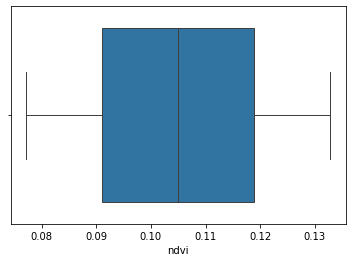

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=metrics['ndvi'])
plt.show()

In [34]:
# from pysal.model import spreg
# X = filtered[['gndvi', 'ndvi']].values
# y = filtered['chl-a'].values
# y.shape = (len(y), 1)
# ls = spreg.ols.OLS(y, X, name_y='chl-a', name_x=['gndvi', 'ndvi'])
# print(ls.summary)

def calculate_chla(collection_images):
    chla_collection = collection_images.map(lambda image: image.expression(
        '3.72 -2.77 * gndvi -18.69 * ndvi',
        {
            'gndvi': calculate_gndvi_image(image),
            'ndvi': calculate_ndvi_image(image)
        }
    ))
    return chla_collection


def calculate_gndvi_image(image):
    gndvi = image.expression(
        '(NIR - GREEN) / (NIR + GREEN)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    )
    return gndvi
    
def calculate_ndvi_image(image):
    ndvi = image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    )
    return ndvi



In [36]:
fecha = '2023-05-03'

dayOfInterest = ee.Date(fecha)

sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
.filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
.filterBounds(aoi_bbox)

calculate_chla_image = calculate_chla(sentinel2_collection).first()

# Parámetros de visualización
visParams = {
    'min': 0,
    'max': 5,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']   
}

# Visualización de la imagen
Map = geemap.Map(center=[-45.37232, -73.50121], zoom=16)
Map.addLayer(calculate_chla_image, visParams, 'CHL-A')
# Map.addLayer(aoi, {}, 'AOI')
Map.add_colorbar(visParams, label="CHL-A")
Map

Map(center=[-45.37232, -73.50121], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [39]:
bloom_enero, images = get_copernicus_collection(aoi_bbox, ['2022-12-15', '2023-02-15'])
chla_bloom_enero = calculate_chla(bloom_enero)
videoArgs = {'dimensions': 768,
             'region': aoi_bbox,
             'framesPerSecond': 2,
             'crs': 'EPSG:32719',
             'min': 0,
             'max': 5,
             'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

print(chla_bloom_enero.getVideoThumbURL(videoArgs))

Se obtuvieron 4 imágenes del COPERNICUS
https://earthengine.googleapis.com/v1/projects/cibravo2/videoThumbnails/4686ef6e1ded381b6f9c429a1df4dcf5-699c933a827e39e3d4c400bd73a73885:getPixels
